In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [73]:
df = pd.read_csv('Algerian_forest_fires_dataset_clean.csv')
df.head()

,region,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
0,0,1,6,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,Not Fire
1,0,2,6,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,Not Fire
2,0,3,6,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,Not Fire
3,0,4,6,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,Not Fire
4,0,5,6,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,Not Fire


In [74]:
df.columns

Index(['region', 'day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain',
       'FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes'],
      dtype='object')

In [75]:
#drop feature classes
df.drop(columns=['day', 'month', 'year'], inplace=True)

In [76]:
#differentiate dependent and independent features
X = df.drop(columns=['FWI'])
y = df['FWI']
X.head()

,region,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,Classes
0,0,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,Not Fire
1,0,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,Not Fire
2,0,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,Not Fire
3,0,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,Not Fire
4,0,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,Not Fire


In [77]:
#Encoding the classes feature
X['Classes'] = np.where(X['Classes']=='Not Fire',0,1)
X['Classes'].value_counts()

,count
Classes,
1,137
0,106


In [182]:
#train test split with test size as 0.25 and random state 42
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (182, 11)
X_test shape:  (61, 11)
y_train shape:  (182,)
y_test shape:  (61,)


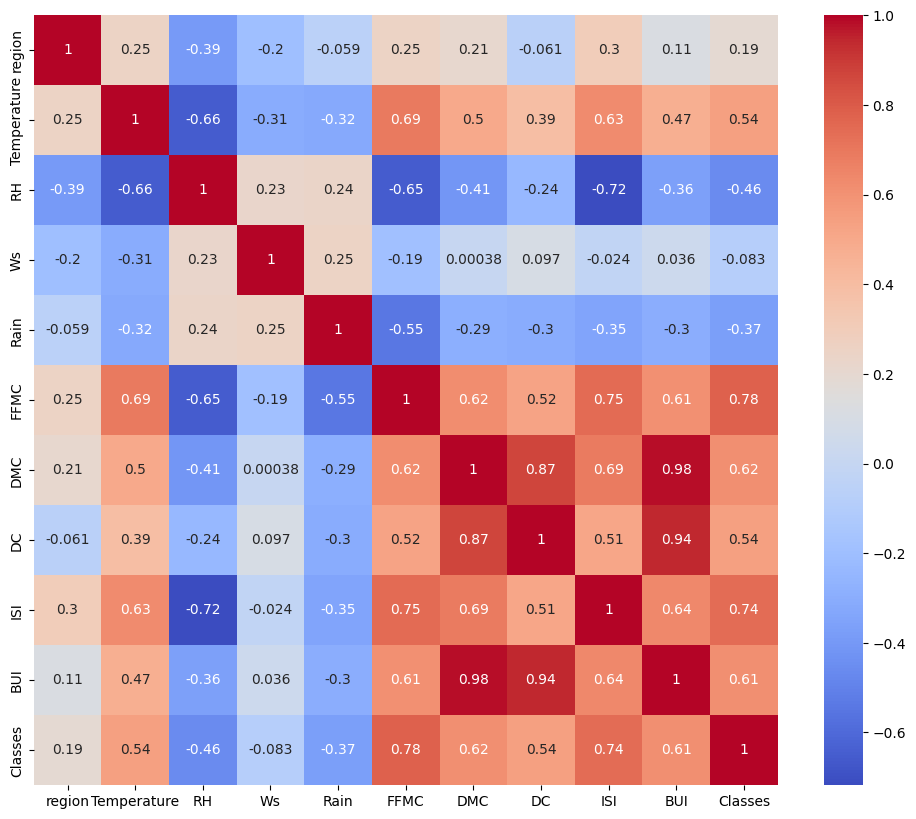

In [183]:
# plot a heat map for all the features in X_train
plt.figure(figsize=(12, 10))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm')
plt.show()


In [184]:
# Calculate the correlation matrix
corr_matrix = X_train.corr().abs()

# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.85
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
print("Features to drop due to high correlation:", to_drop)

# Drop the collinear features from X_train and X_test
X_train.drop(columns=to_drop, inplace=True)
X_test.drop(columns=to_drop, inplace=True)

Features to drop due to high correlation: ['DC', 'BUI']


In [185]:
X_train.head()

,region,Temperature,RH,Ws,Rain,FFMC,DMC,ISI,Classes
97,0,29,74,19,0.1,75.8,3.6,2.1,0
141,1,31,72,14,0.2,60.2,3.8,0.8,0
192,1,40,31,15,0.0,94.2,22.5,16.6,1
68,0,32,60,18,0.3,77.1,11.3,2.2,0
119,0,32,47,14,0.7,77.5,7.1,1.8,0


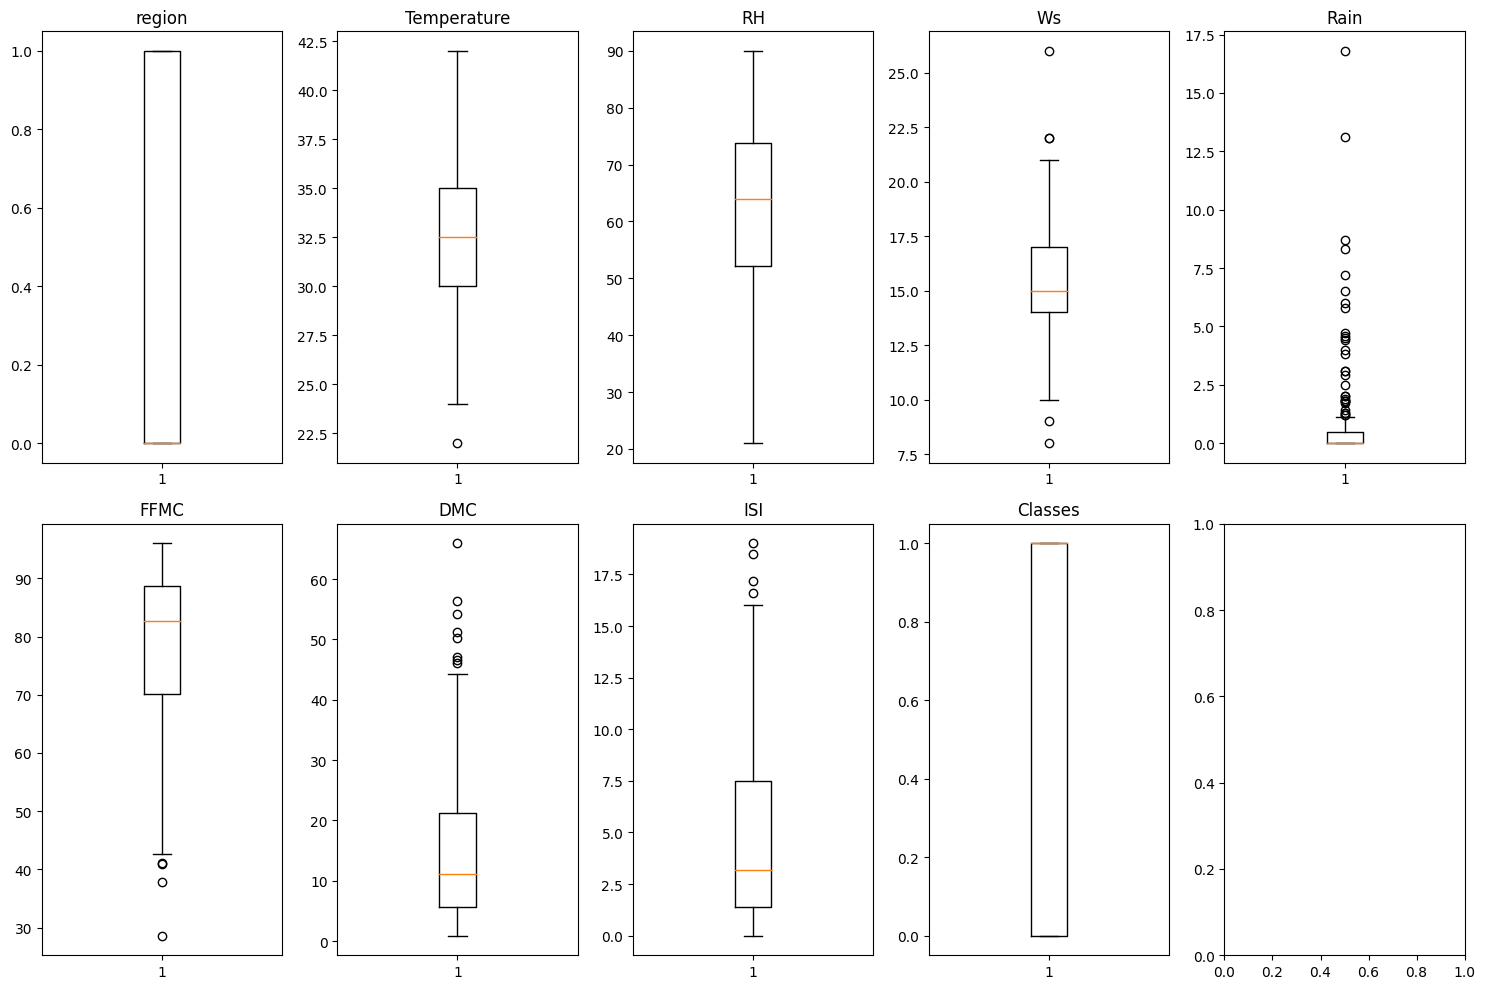

In [186]:
#Plot a box plot for all the features to check outliers

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through columns and plot boxplots
for i, column in enumerate(X_train.columns):
  axes[i].boxplot(X_train[column])
  axes[i].set_title(column)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [187]:
#select the numerical columns
columns_to_not_handle = ['region', 'Classes']
columns_to_handle = [col for col in X_train.columns if col not in columns_to_not_handle]

In [188]:
#replace the outliers with Nan and save the boundaries to .json file

# Dictionary to store the bounds for each column
outlier_bounds = {}

# Loop over each column and handle outliers
for col in columns_to_handle:
    # Calculate Q1 (25th percentile) and Q3 (75th percentile) for X_train
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define lower and upper bound for outlier detection
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Save the bounds in the dictionary
    outlier_bounds[col] = {'lower_bound': lower_bound, 'upper_bound': upper_bound}

    # Replace outliers in X_train with np.nan
    X_train.loc[(X_train[col] < lower_bound) | (X_train[col] > upper_bound), col] = np.nan

    # Replace outliers in X_test with np.nan (using the same bounds calculated from X_train)
    X_test.loc[(X_test[col] < lower_bound) | (X_test[col] > upper_bound), col] = np.nan

# Save the bounds into a JSON file
with open('outlier_bounds.json', 'w') as f:
    json.dump(outlier_bounds, f, indent=4)

print("Outlier bounds saved to 'outlier_bounds.json'")


Outlier bounds saved to 'outlier_bounds.json'


In [189]:
# use Robust scalar to scale the numerical columns

from sklearn.preprocessing import RobustScaler

# Initialize the RobustScaler
scaler = RobustScaler()

# Fit and transform the scaler on the training data
X_train[columns_to_handle] = scaler.fit_transform(X_train[columns_to_handle])

# Transform the test data using the same scaler
X_test[columns_to_handle] = scaler.transform(X_test[columns_to_handle])


In [190]:
X_train.head()

,region,Temperature,RH,Ws,Rain,FFMC,DMC,ISI,Classes
97,0,-0.8,0.465116,1.333333,0.8,-0.415094,-0.493870,-0.167364,0
141,1,-0.4,0.372093,-0.333333,1.6,-1.320755,-0.479860,-0.384937,0
192,1,1.4,-1.534884,0.000000,0.0,0.653120,0.830123,NaN,1
68,0,-0.2,-0.186047,1.000000,2.4,-0.339623,0.045534,-0.150628,0
119,0,-0.2,-0.790698,-0.333333,5.6,-0.316401,-0.248687,-0.217573,0


In [191]:
#use KNN imputer to impute missing values(outliers)
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
X_train[columns_to_handle] = imputer.fit_transform(X_train[columns_to_handle])
X_test[columns_to_handle] = imputer.transform(X_test[columns_to_handle])

# Linear Regression

MAE:  0.9184775777345993
R2:  0.9346344369707866


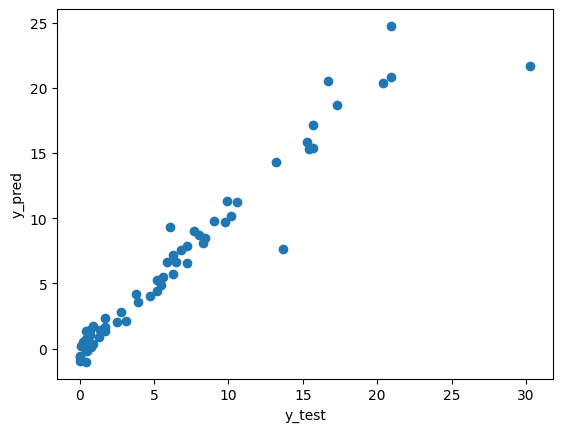

In [192]:
#Apply linear regression and obtain MAE and r-squared
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MAE: ', mae)
print('R2: ', r2)
#plot a scatter plot between y_test and y_pred
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

MAE:  0.8998145314687466
R2:  0.9350112770508594


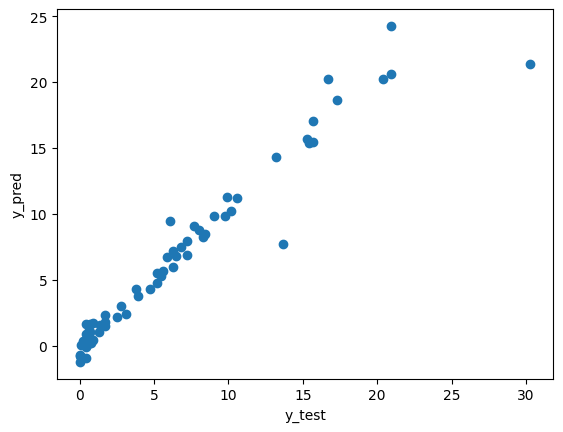

In [193]:
#Apply Ridge regression and obtain MAE and r-squared
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score
regressor = Ridge()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MAE: ', mae)
print('R2: ', r2)
#plot a scatter plot between y_test and y_pred
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

MAE:  0.9151894688213351
R2:  0.9347392584872699


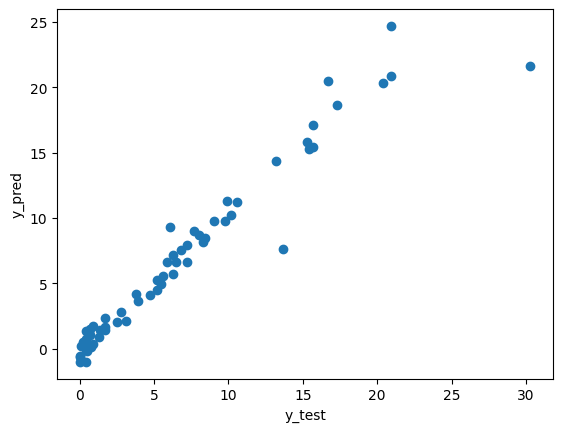

In [194]:
#Apply RidgeCV and obtain MAE and r-squared
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_absolute_error, r2_score
cross_validator = RidgeCV(cv = 5)
cross_validator.fit(X_train, y_train)
y_pred = cross_validator.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MAE: ', mae)
print('R2: ', r2)
#plot a scatter plot between y_test and y_pred
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

MAE:  1.490388196709667
R2:  0.8835322091630116


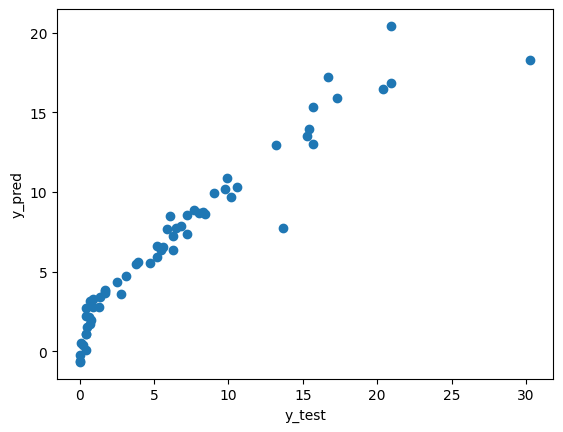

In [195]:
#Apply lasso regression and obtain MAE and r-squared
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, r2_score
regressor = Lasso()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MAE: ', mae)
print('R2: ', r2)
#plot a scatter plot between y_test and y_pred
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

MAE:  0.8914048878223348
R2:  0.9358232806867981


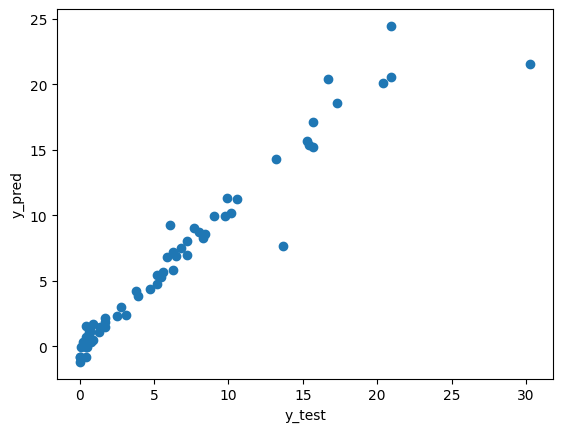

In [196]:
#Apply LassoCV and obtain MAE and r-squared
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_absolute_error, r2_score
Lasso_cross_validator = LassoCV(cv = 5)
Lasso_cross_validator.fit(X_train, y_train)
y_pred = Lasso_cross_validator.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MAE: ', mae)
print('R2: ', r2)
#plot a scatter plot between y_test and y_pred
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

MAE:  2.500108447581757
R2:  0.748875912460434


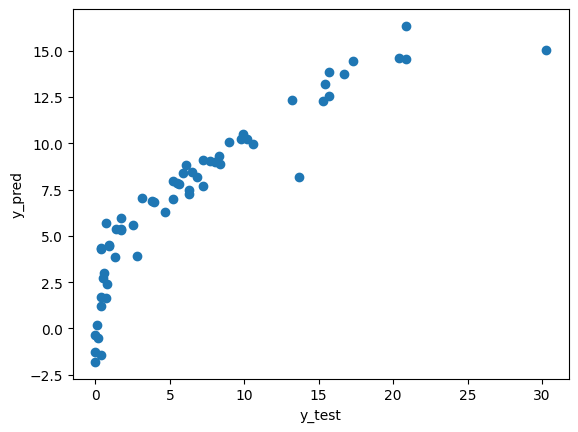

In [197]:
#Apply ElasticNet regression and obtain MAE and r-squared
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, r2_score
regressor = ElasticNet()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MAE: ', mae)
print('R2: ', r2)
#plot a scatter plot between y_test and y_pred
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

MAE:  0.9031251516993506
R2:  0.9344691830642402


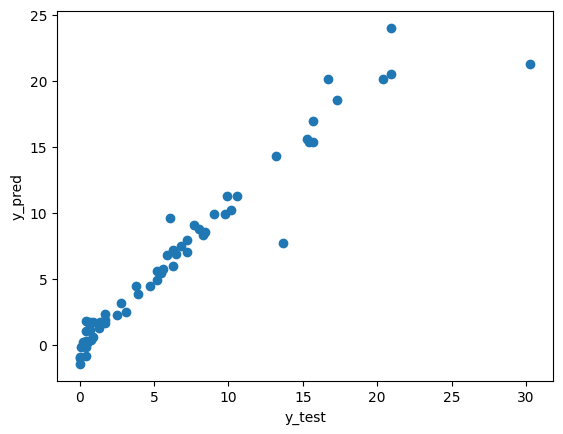

In [198]:
#Apply ElasticNetCV and obtain MAE and r-squared
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_absolute_error, r2_score
cross_validator = ElasticNetCV(cv = 5)
cross_validator.fit(X_train, y_train)
y_pred = cross_validator.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('MAE: ', mae)
print('R2: ', r2)
#plot a scatter plot between y_test and y_pred
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

In [199]:
#Picle the LassoCV model and RobustScalar, KNNImputer
import pickle
with open('/content/drive/MyDrive/machine_learning/Regression/LassoCV.pkl', 'wb') as f:
    pickle.dump(Lasso_cross_validator, f)
with open('/content/drive/MyDrive/machine_learning/Regression/RobustScalar.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('/content/drive/MyDrive/machine_learning/Regression/KNNImputer.pkl', 'wb') as f:
    pickle.dump(imputer, f)